# Automated Process Mining using pm4py and pyspark

Below are the libraries and APIs to be used.

- `pickle` for object (de)serialization
- `pyspark` spark API in Python
- `pm4py` an open source process mining python library
- `matplotlib` an open source library for plotting

In [1]:
import sys
import pickle
import time
from string import Template

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, broadcast, col, lag, lead, unix_timestamp, collect_set, collect_list, explode, row_number, array_contains, monotonically_increasing_id, size, split, lit, map_concat, map_from_arrays, map_keys, map_values, map_from_entries, struct
from pyspark.sql.types import StringType, IntegerType, LongType, StructType, StructField, MapType, ArrayType, ByteType, TimestampType

from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

`directSuccessionFrequency` is an RDD transformation that is used to transform records into the following form:

`ACTIVITY_1 [ 
    [Predecessor1, Frequency1] .. [PredecessorN, FreqencyN], 
    [Successor1, Frequency1] .. [SuccessorN, FreqencyN],
]`

**Such that, ( Predecessor {1,} )->(Activity)->( Successor{0,} )**

In [2]:
preparationStartTime = time.time()

In [3]:
def directSuccessionFrequency(record):
    predecessorSet = set(record[1])
    successorSet = set(record[2])
    
    predecessorOutput = []
    successorOutput = []
    
    for item in predecessorSet:
        predecessorOutput.append(tuple([item, record[1].count(item)]))
        
    for item in successorSet:
        successorOutput.append(tuple([item, record[2].count(item)]))
    
    return (record[0], predecessorOutput, successorOutput)

Configuring spark in order to handle real big data.

- `spark.executor.memory`: is the memory amount required for executing the tasks (heap size)


- `spark.executor.cores`: is the number of tasks that can be running at the same time by the same executor


- `spark.executor.instances`: is the number of the executors on the worker


- `spark.driver.memory`: is the memory amount to maintain for the driver to recieve the data


- `spark.eventLog.enabled`: is to enable the log history for the job for monitoring


- `spark.driver.maxResultSize`: is the total size of serialized result

In [4]:
conf=SparkConf()
conf.set("spark.executor.memory", "10g")
conf.set("spark.executor.cores", "10")
conf.set("spark.executor.instances", "10")
conf.set("spark.driver.memory", "13g")
conf.set("spark.eventLog.enabled", "true")
conf.set("spark.driver.maxResultSize", "15g")

### Setting the schema manually to improve the read time instead of inferring the schema from the data.

In [5]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

schema = StructType([ \
    StructField("Case ID",StringType(),True), \
    StructField("Event ID",StringType(),True), \
    StructField("Timestamp",StringType(),True), \
    StructField("Activity", StringType(), True), \
    StructField("Resource", StringType(), True), \
    StructField("Costs", IntegerType(), True) \
  ])

In [6]:
new_log = spark.read.csv("./BPIC15_5.csv", header=True)

### Renaming the columns to the namings that the miners understand

In [7]:
new_log = new_log.withColumnRenamed("org:resource", "Resource")\
        .withColumnRenamed("activityNameEN", "Activity")\
        .withColumnRenamed("case:concept:name", "Case ID")\
        .withColumnRenamed("concept:name", "Event ID")\
        .withColumnRenamed("time:timestamp", "Timestamp")\
        .withColumn("Costs", lit(1))

In [8]:
new_log = new_log.select('Case ID', 'Event ID', 'Timestamp', 'Activity', 'Resource', 'Costs')

In [9]:
# rdd_log = spark.read.csv("./alpha_miner.csv", header=True, sep=',', schema=schema)
new_ts_schema = 'yyyy-MM-dd HH:mm:ss'
old_ts_schema = 'dd-MM-yyyy:HH.mm'
new_log = new_log.withColumn("Timestamp", unix_timestamp(new_log['Timestamp'], new_ts_schema))

In [10]:
df = new_log

### Partitioning and windowing by Case ID then sorting by timestamp ascendingly

### Then calculating the predecessor and successors for each activity by using lag for predecessor and lead for predecessor

In [11]:
directSuccessionWindow = Window.partitionBy("Case ID").orderBy("Timestamp")

In [12]:
df = df.withColumn("predecessor",lag("Activity",1).over(directSuccessionWindow))
df = df.withColumn("successor",lead("Activity",1).over(directSuccessionWindow))

In [13]:
direct_succession_freq = df.select("activity", "predecessor", "successor").groupby("activity").agg(collect_list("predecessor").alias("predecessor"), collect_list("successor").alias("successor"))
direct_succession = df.select("activity", "predecessor", "successor").groupby("activity").agg(collect_set("predecessor").alias("predecessor"), collect_set("successor").alias("successor"))

### Then after finding the predecessor and successor, use the directSuccessionFrequency transformer in order to transform the record into the format mentioned in the documentation of the transformer (above)

In [14]:
direct_succession_freq = direct_succession_freq.rdd.map(directSuccessionFrequency).toDF(["activity", "predecessor", "successor"])

### Creating the query from the generated transformation, thus will be used in neo4j to generate the dfg on that side

### The same query is used for incremental updates over the dfg that was stored inside neo4j

In [15]:
def getQuery(activity, predecessor, successor):
    predecessorQuery = ""
    successorQuery = ""
    for element in predecessor:
        query = Template(
        '''
        MERGE (p:Activity {name: '$parentName'})
        MERGE (c:Activity {name: '$activityName'})
        MERGE (p)-[r:PRODUCES]->(c)
        ON CREATE SET r.cost = $cost
        ON MATCH SET r.cost = r.cost + $cost
        RETURN 1;
        \n
        ''').substitute(parentName=element[0], cost=element[1], activityName=activity)
        predecessorQuery += query
        
    for element in successor:
        query = Template('''
        MERGE (p:Activity {name: '$activityName'})
        MERGE (c:Activity {name: '$childName'})
        MERGE (p)-[r:PRODUCES]->(c)
        ON CREATE SET r.cost = $cost
        ON MATCH SET r.cost = r.cost + $cost
        RETURN 1;
        \n
        ''').substitute(childName=element[0], cost=element[1], activityName=activity)
        successorQuery += query
        
    return predecessorQuery + successorQuery[:-1]

In [16]:
get_query = udf(lambda activity, predecessor, successor: getQuery(activity, predecessor, successor), StringType())

In [17]:
direct_succession_freq = direct_succession_freq.withColumn("query", get_query("activity", "predecessor", "successor"))

### Selecting the query column separately to be sent to neo4j

In [18]:
queries = direct_succession_freq.select("query")

### Then post-processing the selected query by adding the following:
- ```apoc.cypher.runMany``` is a method that runs many queries simultaneously

In [19]:
query = "CALL apoc.cypher.runMany(\""
for record in queries.collect():
    query += record[0]

In [20]:
query += "\", {}, {statistics: false}) YIELD result RETURN 1;"

### Enclosing the string and finalizing the query that will be sent to neo4j connector in order to execute it, in addition to replacing any special character or carriage tab or return, this to guarantee that the query is valid

In [21]:
query2 = query.replace("\t", "").replace("\\", "")

### Specifying the credentials and authorization to access the proper neo4j instance

In [22]:
host="bolt://localhost:7687"
user="neo4j"
password="test"

### Sending the creation query to neo4j

In [23]:
result = queries.select().limit(1).write.format("org.neo4j.spark.DataSource") \
    .option("url", host) \
    .option("authentication.type", "basic") \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option("query", query2) \
    .save()

In [24]:
preparationExecutionTime = time.time() - preparationStartTime

dfgAlgorithmsStart = time.time()

### Below is the query that gets the DFG

In [25]:
readQuery = "MATCH result=(p:Activity)-[r:PRODUCES]->(c:Activity) RETURN p.name as Parent, c.name as Child, r.cost as Frequency"

In [26]:
df = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", host) \
    .option("authentication.type", "basic") \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option("query", readQuery) \
    .load()

### Converting the DFG that was fetched from neo4j to the format that pm4py used to understand.

```
{
    (Parent_1, Child_1): Frequency_1,
    (Parent_2, Child_2): Frequency_2
}

```

In [27]:
def flattenDFG(dfg):
    mydict = {}
    for item in dfg:
        mydict.update(item)
    return mydict

flatten_dfg = udf(lambda dfg: flattenDFG(dfg), MapType(StructType([StructField("parent", StringType(), True), StructField("child", StringType(), True)]), IntegerType()))

def getDFG(p,c,f):
    return {(p,c):f}

get_dfg = udf(lambda p,c,f: getDFG(p,c,f), MapType(StructType([StructField("parent", StringType(), True), StructField("child", StringType(), True)]), IntegerType()))

### Preparing the udfs for each miner

**Each UDF takes the DFG as input and returns a pickled object representing the net**

*By this approach, we were able to store a different type of object rather than the primitives in pyspark.*

In [28]:
def alphaMiner(dfg):
    net, initial_marking, final_marking = alpha_miner.apply_dfg(dfg)
    return str(pickle.dumps({'net': net, 'im': initial_marking, 'fm': final_marking}), encoding="latin1")

def heuristicMiner(dfg, threshold):
    net, im, fm = heuristics_miner.apply_dfg(dfg, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: threshold})
    return str(pickle.dumps({'net': net, 'im': im, 'fm': fm}), encoding="latin1")

def inductiveMiner(dfg, threshold):
    net, im, fm = inductive_miner.apply_dfg(dfg, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: threshold})
    return str(pickle.dumps({'net': net, 'im': im, 'fm': fm}), encoding="latin1")

alpha_miner_alg = udf(lambda dfg: alphaMiner(dfg))
heuristic_miner_alg = udf(lambda dfg, threshold: heuristicMiner(dfg, threshold))
inductive_miner_alg = udf(lambda dfg, threshold: inductiveMiner(dfg, threshold))

### Getting the DFG that will be passed to each miner in parallel

In [29]:
DFG = df.withColumn("dfg", get_dfg(df.Parent, df.Child, df.Frequency)).withColumn("threshold", lit(0.99))

In [30]:
# DFG.toPandas()
DFG = DFG.agg(collect_list('dfg').alias('dfg')).withColumn("dfg", flatten_dfg("dfg")).withColumn("threshold", lit(0.99))

### Calling each miner with different miner algorithm on the same DFG

In [31]:
# alphaMinerDF = DFG.withColumn("petrinet", alpha_miner_alg("dfg"))

heuristicMinerDF = DFG.withColumn("petrinet", heuristic_miner_alg("dfg", "threshold"))

inductiveMinerDF = DFG.withColumn("petrinet", inductive_miner_alg("dfg", "threshold"))

In [32]:
dfgAlgorithmsExecutionTime = time.time() - dfgAlgorithmsStart

evaluationStartTime = time.time()

In [33]:
new_log = new_log.withColumn("concept:name", col("Activity")).withColumnRenamed("Case ID", "case:concept:name").withColumnRenamed("Timestamp", "time:timestamp")

In [34]:
DFG.withColumn("petrinet", heuristic_miner_alg("dfg", "threshold")).show()

+--------------------+---------+--------------------+
|                 dfg|threshold|            petrinet|
+--------------------+---------+--------------------+
|[[generate public...|     0.99|}q (X   netqc...|
+--------------------+---------+--------------------+



### Selecting the petrinet object from the Dataframe of each algorithm in order to run evaluators on top of it

In [35]:
# alphaMinerNet = alphaMinerDF.select('petrinet').collect()[0][0]
heiristicMinerNet = heuristicMinerDF.select('petrinet').collect()[0][0]
inductiveMinerNet = inductiveMinerDF.select('petrinet').collect()[0][0]

### Deserializing the extracted petrinet object of each algorithm in order to be used for evaluators

In [36]:
# alphapn = pickle.loads(bytes(alphaMinerNet, "latin1"))
heuristicpn = pickle.loads(bytes(heiristicMinerNet, "latin1"))
inductivepn = pickle.loads(bytes(inductiveMinerNet, "latin1"))

### Converting the RDD to pandas
### Converting the grouped (simplified) RDD to pandas

#### This is primarily done because of the current implementation of the evaluators require the log to be in pandas format

In [37]:
new_log.columns

['case:concept:name',
 'Event ID',
 'time:timestamp',
 'Activity',
 'Resource',
 'Costs',
 'concept:name']

In [38]:
# pandas_rdd = new_log.toPandas()
merged_rdd = spark.read.csv("./merged_1_2_3_4_5.csv", header=True)
merged_rdd = merged_rdd.withColumnRenamed("org:resource", "Resource")\
        .withColumnRenamed("activityNameEN", "Activity")\
        .withColumn("Costs", lit(1))

merged_rdd = merged_rdd.select('case:concept:name', 'concept:name', 'time:timestamp', 'Activity', 'Resource', 'Costs')

merged_rdd = merged_rdd.withColumn("time:timestamp", unix_timestamp(merged_rdd['time:timestamp'], new_ts_schema))
pandas_rdd = merged_rdd.toPandas()

In [39]:
# merged_rdd.columns

### Calculating the evaluation metrics over each petrinet object

- Simplicity
- Fitness
- Precision
- Generalization

***And eventually summing up all of the values for all evaluators and labeling it as the score***

In [40]:
def getEvaluationMetrics(pandasRdd, petrinetObject):
    simplicity = simplicity_evaluator.apply(petrinetObject['net'])
    fitness = replay_fitness_evaluator.apply(pandasRdd, petrinetObject['net'], petrinetObject['im'], petrinetObject['fm'], variant=replay_fitness_evaluator.Variants.TOKEN_BASED)["log_fitness"]
    precision = precision_evaluator.apply(pandasRdd, petrinetObject['net'], petrinetObject['im'], petrinetObject['fm'], variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
    generalization = generalization_evaluator.apply(pandasRdd, petrinetObject['net'], petrinetObject['im'], petrinetObject['fm'])
    
    return {"simplicity" : simplicity, 
            "fitness": fitness, 
            "precision": precision, 
            "generalization": generalization,
            "score": simplicity+fitness+precision+generalization
           }

In [41]:
print("Alpha Miner Score")
# alphaMinerEvaluation = getEvaluationMetrics(pandas_rdd, alphapn)

Alpha Miner Score


In [42]:
print("Hueristic Miner Score")
heuristicMinerEvaluation = getEvaluationMetrics(pandas_rdd, heuristicpn)

Hueristic Miner Score


replaying log with TBR, completed variants ::   0%|          | 0/5540 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/187963 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5540 [00:00<?, ?it/s]

In [43]:
print("Inductive Miner Score")
inductiveMinerEvaluation = getEvaluationMetrics(pandas_rdd, inductivepn)

Inductive Miner Score


replaying log with TBR, completed variants ::   0%|          | 0/5540 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/187963 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/5540 [00:00<?, ?it/s]

In [44]:
evaluationExecutionTime = time.time() - evaluationStartTime

In [45]:
print(evaluationExecutionTime)
print(evaluationStartTime)

5981.792769908905
1636456142.1252859


In [46]:
print(dfgAlgorithmsExecutionTime)
print(dfgAlgorithmsStart)

1.1583421230316162
1636456140.9669192


In [47]:
print(preparationExecutionTime)
print(preparationStartTime)

13.883137702941895
1636456127.0836706


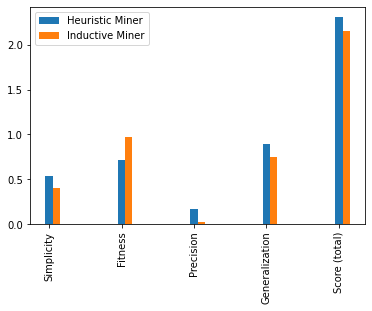

In [48]:
labels = ['Simplicity', 'Fitness', 'Precision', 'Generalization', 'Score (total)']
# alpha_means = [
#     alphaMinerEvaluation['simplicity'], 
#     alphaMinerEvaluation['fitness'], 
#     alphaMinerEvaluation['precision'], 
#     alphaMinerEvaluation['generalization'],
#     alphaMinerEvaluation['score']
# ]
heuristic_means = [
    heuristicMinerEvaluation['simplicity'], 
    heuristicMinerEvaluation['fitness'], 
    heuristicMinerEvaluation['precision'], 
    heuristicMinerEvaluation['generalization'],
    heuristicMinerEvaluation['score']
]
inductive_means = [
    inductiveMinerEvaluation['simplicity'], 
    inductiveMinerEvaluation['fitness'], 
    inductiveMinerEvaluation['precision'], 
    inductiveMinerEvaluation['generalization'],
    inductiveMinerEvaluation['score']
]

Pos = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

# plt.bar(Pos - width, alpha_means, width = width, label = 'Alpha Miner')
plt.bar(Pos, heuristic_means, width = width, label = 'Heuristic Miner')
plt.bar(Pos + width, inductive_means, width = width, label = 'Inductive Miner')

plt.xticks(range(len(labels)), labels, rotation=90)

plt.legend()
plt.show()

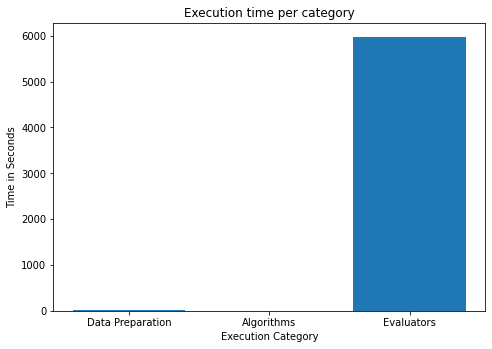

In [49]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.set_title('Execution time per category')
ax.set_ylabel('Time in Seconds')
ax.set_xlabel('Execution Category')
labels = ['Data Preparation', 'Algorithms', 'Evaluators']
values = [preparationExecutionTime, dfgAlgorithmsExecutionTime, evaluationExecutionTime]
ax.bar(labels,values)
plt.show()